<a href="https://colab.research.google.com/github/pontonkid/Deep-Learning-with-PyTorch-Neural-Style-Transfer/blob/main/DL_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

## Task 2 : Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models

vgg=models.vgg19(pretrained=True)

print(vgg)

In [ ]:
vgg=vgg.features

print(vgg)

In [6]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
vgg.to(device)

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [15]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path,max_size=500):
    image = Image.open(img_path).convert('RGB')
    if max(image.size)>max_size:
        size=max_size
    else:
        size=max(image.size)

    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406],
                    std=[0.229,0.224,0.225])
    ])

    image = img_transforms(image) 
    image = image.unsqueeze(0)
    return image


In [ ]:
content_p=preprocess('/content/Project-NST/content11.jpg')
style_p=preprocess('/content/Project-NST/style12.jpg')

content_p=content_p.to(device)
style_p=style_p.to(device)

print("content shape", content_p.shape)
print("style shape", style_p.shape)



## Task 4 : Deprocess image

In [17]:
import numpy as np 
import matplotlib.pyplot as plt

def deprocess(tensor):
  image= tensor.to('cpu').clone()

  image= image.numpy()
  image= image.squeeze(0)
  image=image.transpose(1,2,0)
  image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
  image=image.clip(0,1)

  return image


In [ ]:

content_d= deprocess(content_p)
style_d= deprocess(style_p)

print("content shape :" , content_d.shape)
print("style shape :", style_d.shape)


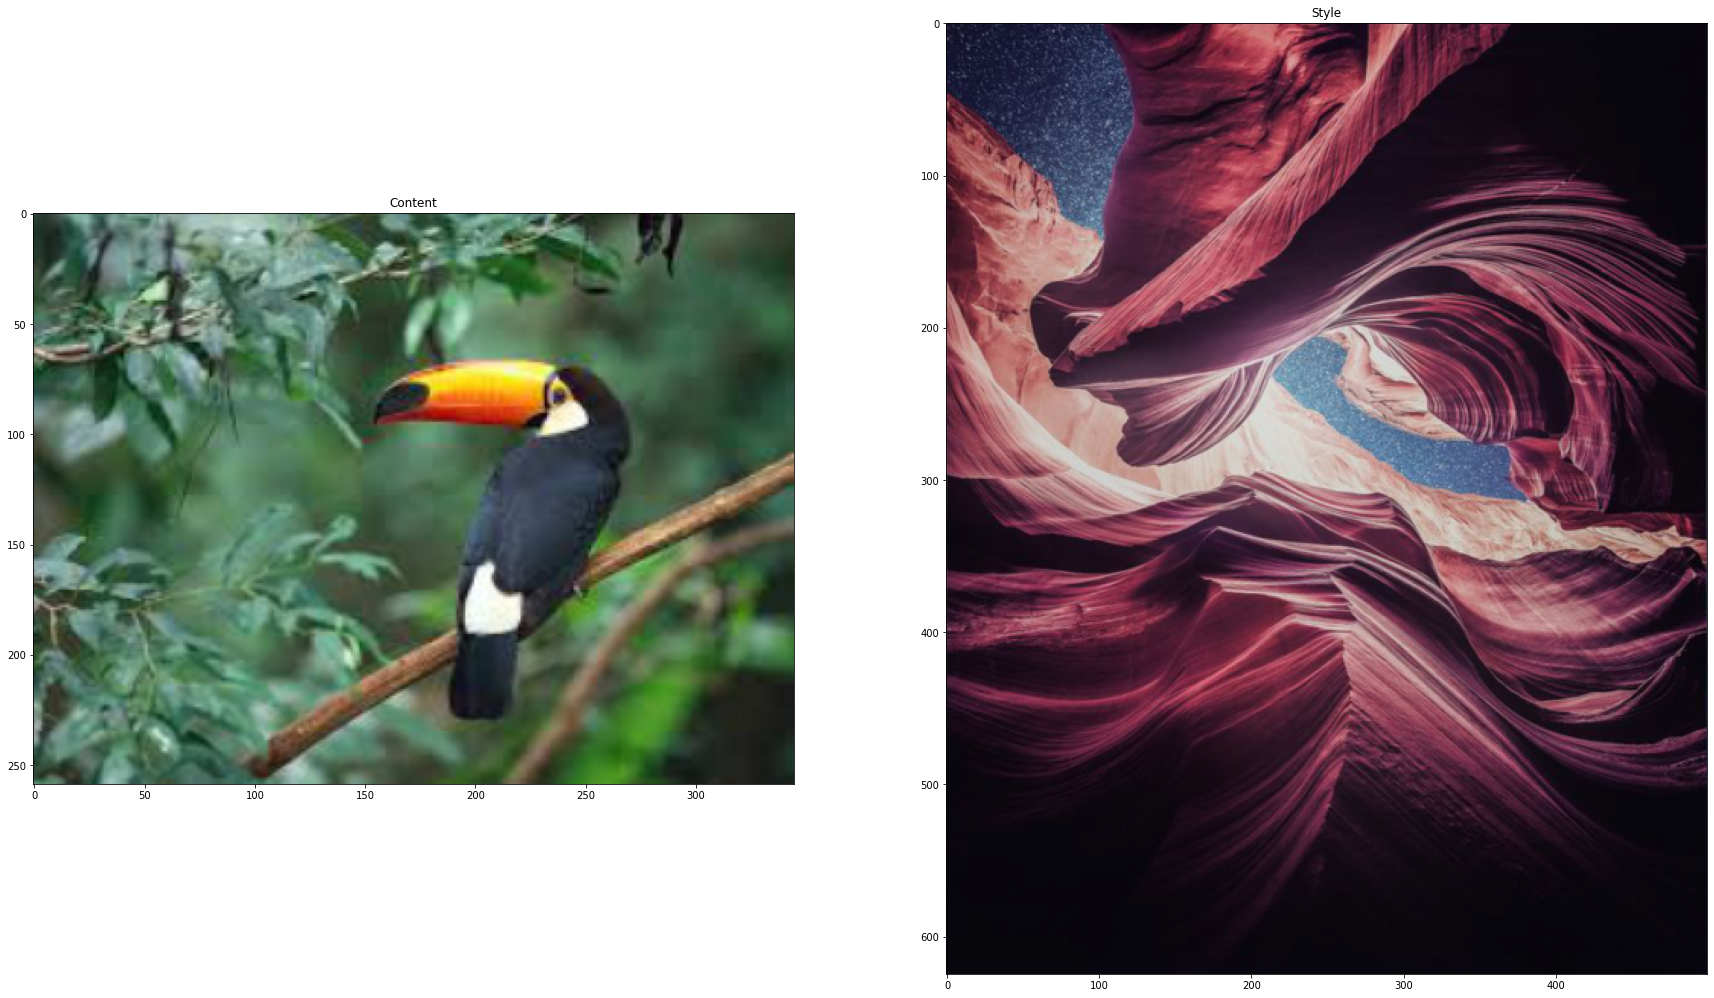

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,20))

ax1.imshow(content_d)
ax1.set_title("Content")
ax2.imshow(style_d)
ax2.set_title("Style")
plt.show()

## Task 5 : Get content,style features and create gram matrix

In [22]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1',
    }

    x = image
    features = {}

    for name, layer in model.features._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [23]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

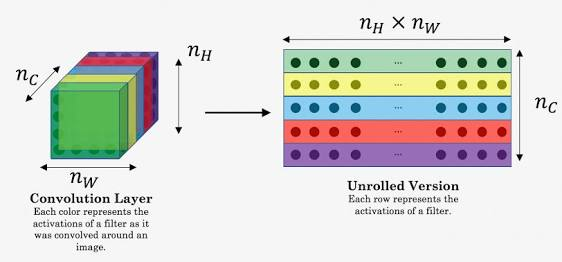

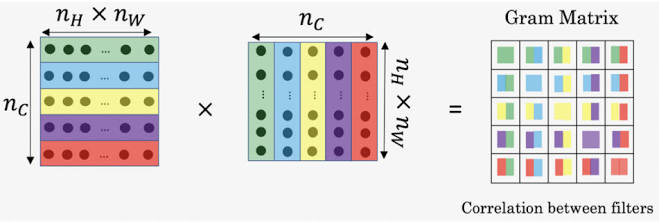

In [26]:
def gram_matrix(tensor):

  b,c,h,w = tensor.size()
  tensor = tensor.view(c,h*w)
  gram = torch.mm(tensor,tensor.t())
  return gram

In [27]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [28]:
def content_loss(target_conv4_2, content_conv4_2):
  
  loss= torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [29]:
style_weights={
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,

}

In [30]:
def style_loss(style_weights, target_f, style_grams):

  loss=0 
  for layer in style_weights:
    target_f= target_f[layer]
    target_gram= gram_matrix(target_f)
    style_gram= style_grams[layer]
    b,c,h,w= target_f.shape
    layer_loss= style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss+=layer_loss/(c*h*w)
    return loss

In [ ]:
target= content_p.clone().requires_grad_(True).to(device)
target_f= get_features(target, vgg)
print("content loss :", content_loss(target_f['conv4_2'], content_f['conv4_2']))
print("style loss :", style_loss(style_weights, target_f, style_grams))

## Task 7 : Training loop

In [33]:
from torch import optim
optimizer= optim.Adam([target], lr=0.003)


alpha=1
beta=1e5

epochs=3000

show_every=300

In [34]:
def total_loss(c_loss, s_loss,alpha,beta):

  loss= alpha*c_loss+beta*s_loss
  return loss

In [ ]:
results=[]
for i in range(epochs):
    target_f = get_features(target, vgg)
    c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
    s_loss = style_loss(style_weights, target_f, style_grams)
    t_loss = total_loss(c_loss, s_loss, alpha, beta)

    optimizer.zero_grad()
    t_loss.backward(retain_graph=True)  # Add retain_graph=True
    optimizer.step()

    if i % show_every == 0:
        print("Total Loss at Epoch {}: {}".format(i, t_loss))
        results.append(deprocess(target.detach()))


In [46]:
plt.figure(figsize= (10,8))


for i in range (len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
  plt.show()



<Figure size 720x576 with 0 Axes>